### Import Libraries and dataset

In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style='darkgrid')
plt.style.use("seaborn-pastel")

df = pd.read_excel("Forbes Athlete List 2012-2019.xlsx")
df.head()

/tmp/ipykernel_29251/1511747903.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-pastel")


,Rank,Name,Pay,Salary/Winnings,Endorsements,Sport,Year
0,#1,Lionel Messi,$127 M,$92 M,$35 M,Soccer,2019
1,#2,Cristiano Ronaldo,$109 M,$65 M,$44 M,Soccer,2019
2,#3,Neymar,$105 M,$75 M,$30 M,Soccer,2019
3,#4,Canelo Alvarez,$94 M,$92 M,$2 M,Boxing,2019
4,#5,Roger Federer,$93.4 M,$7.4 M,$86 M,Tennis,2019


In [8]:
df.Rank = df.Rank.apply(lambda x: int(x.split("#")[1]) if type(x) == str else x)
df.Pay = df.Pay.apply(lambda x: float(x.split(" ")[0].split("$")[1]))
df.Endorsements = df.Endorsements.apply(lambda x: float(x.split(" ")[0].split("$")[1]))
df["Salary/Winnings"].replace("-",'$nan M',inplace=True)
df["Salary/Winnings"] = df["Salary/Winnings"].apply(lambda x: float(x.split(" ")[0].split("$")[1]))
df.Sport.replace({"Soccer":"Football",
                  "Football":"American Football",
                 "Mixed Martial Arts":"MMA",
                 "Auto racing":"Racing",
                  "Auto Racing":"Racing",
                  "Basketbal":"Basketball",
                 },inplace=True)

df.columns = ['Rank', 'Name', 'Pay', 'Salary_Winnings', 'Endorsements', 'Sport', 'Year']

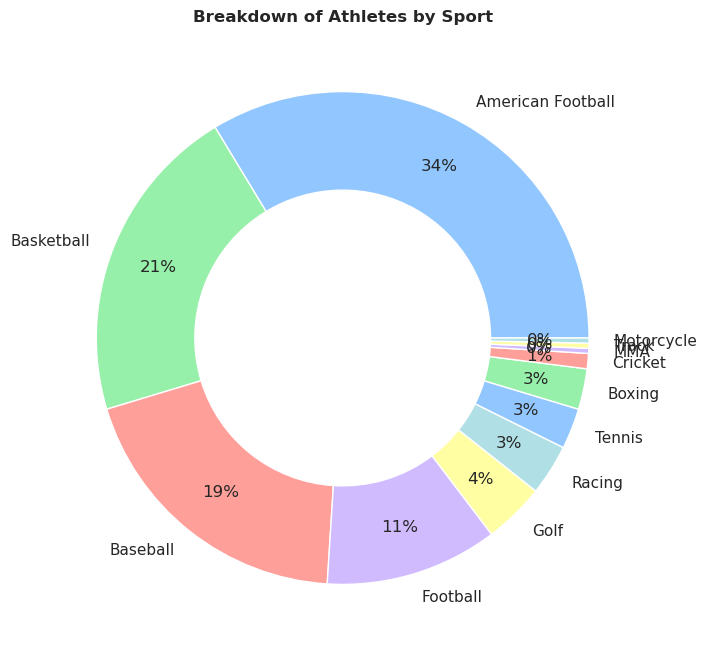

In [9]:
df.groupby("Name").first()["Sport"].value_counts().plot(kind="pie",autopct="%.0f%%",figsize=(8,8),wedgeprops=dict(width=0.4),pctdistance=0.8)
plt.ylabel(None)
plt.title("Breakdown of Athletes by Sport",fontweight="bold")
plt.show()

### Racing Bar Animation

Let’s visualize the cumulative pays of the athletes in a running bar animation. First, we’ll convert the year column to a DateTime object:

In [10]:
df.Year = pd.to_datetime(df.Year,format="%Y")

Next, prepare a pivot table where the columns are the athletes and the index is the years:

In [11]:
racing_bar_data = df.pivot_table(values="Pay",index="Year",columns="Name")

The athletes mentioned below are the only ones who are consistently included in the Top100 list for each year since 2012. The rest of the athletes have NaN values. We will first interpolate the NaNs linearly and use the filling of the remaining NaNs with backfilling:

In [12]:
racing_bar_data.columns[racing_bar_data.isnull().sum()==0]

Index(['Carmelo Anthony', 'Cristiano Ronaldo', 'Dwight Howard',
       'Justin Verlander', 'LeBron James', 'Lionel Messi', 'Phil Mickelson',
       'Rafael Nadal', 'Roger Federer', 'Tiger Woods'],
      dtype='object', name='Name')

Now convert the data to a cumulative payroll sum over several years:

In [13]:
racing_bar_filled = racing_bar_data.interpolate(method="linear").fillna(method="bfill")
racing_bar_filled = racing_bar_filled.cumsum()

Now, let’s oversample the dataset with interpolation (linear) for a smooth transition in the frames of the animation:

In [14]:
racing_bar_filled = racing_bar_filled.resample("1D").interpolate(method="linear")[::7]

### Creating and Saving a Bar Chart Animation with Python

Now let’s import the Python packages needed to create and save animations, and run paths and their elements (lines, bars, texts, etc.). The code below will generate an animation for the 10 highest-paid athletes between 2012 and 2019:

In [17]:
from matplotlib.animation import FuncAnimation, FFMpegWriter

selected = racing_bar_filled.iloc[-1,:].sort_values(ascending=False)[:20].index
data = racing_bar_filled[selected].round()

fig,ax = plt.subplots(figsize=(9.3,7))
fig.subplots_adjust(left=0.18)
no_of_frames = data.shape[0] # Number of frames

# initiate the barplot with first rows of the dataframe
bars = sns.barplot(y=data.columns,x=data.iloc[0,:],orient="h",ax=ax)
ax.set_xlim(0,1500)
txts = [ax.text(0,i,0,va="center") for i in range(data.shape[1])]
title_txt = ax.text(650,-1,"Date: ",fontsize=12)
ax.set_xlabel("Pay (Millions USD)")
ax.set_ylabel(None)

def animate(i):
    y = data.iloc[i,:]
    # Update title of the barplot axis
    title_txt.set_text(f"Date: {str(data.index[i].date())}")

    # Update elements in both plots
    for j, b, in enumerate(bars.patches):
        # update each bar's height
        b.set_width(y[j])

        # Update text for each bar
        txts[j].set_text(f"${y[j].astype(int)}M")
        txts[j].set_x(y[j])

anim=FuncAnimation(fig,animate,repeat=False,frames=no_of_frames,interval=1,blit=False)
anim.save('athletes.gif',writer='pillow',fps=120)
plt.close(fig)

Source:

https://thecleverprogrammer.com/2020/12/21/highest-paid-athletes-analysis-with-python/